In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
plt.rc('text', usetex=True)
plt.rc('font', size=22, **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['savefig.bbox'] = 'tight'

In [33]:
def plot(relabeling=False, save=True):
    name = 'results_random_relabeling.xlsx' if relabeling else 'results.xlsx'
    df = pd.read_excel(name, index_col='Name')

    n_gcc_final = []
    n_ap = []
    for dataset in df.index.unique():
        # if dataset in datasets_to_plot:
            s_GCC = df.loc[dataset, 's_GCC']
            n_gcc_final.append(s_GCC.values if hasattr(s_GCC, 'values') else [s_GCC])
            n_AP = df.loc[dataset, 'n_AP']
            n_ap.append(n_AP.values if hasattr(n_AP, 'values') else [n_AP])

    fmts = ['o--', 's--', '^--', 'x--', 'v--', 'P--', '*--', '.--',
            '4--', '<--', '>--', 'p--', 'h--', 'H--', '+--', 'D--',
            '1--', '2--', '3--', '8--', 'X--', 'd--', '|--', '_--']
    fmts = [fmt[0] for fmt in fmts]

    fig, ax = plt.subplots(figsize=(20, 13))
    
    print(len(n_gcc_final))
    print(len(n_ap))
    print(len(df.index.unique()))

    for x, y, fmt, lbl in zip(
        n_gcc_final,
        n_ap,
        fmts,
        df.index.unique(),
    ):
        ax.plot(x[-1], y[0], fmt, label=lbl, ms=8)

    ax.set_xlabel(r'$n_{\textrm{GMCC}}^{\textrm{real}}$')
    ax.set_ylabel(r'$n_{\textrm{AP}}^{\textrm{real}}$')

    ax.set_xlim(0, 1)
    # ax.set_ylim(0, 1)

    # ax.invert_xaxis()

    ax.legend(prop={'size': 14})

    if save:
        fig.savefig(f'AP_vs_GCC{"_relabeled" if relabeling else ""}_work_revision.png')
        fig.savefig(f'AP_vs_GCC{"_relabeled" if relabeling else ""}_work_revision.pdf')

    return n_ap, n_gcc_final

23
23
23


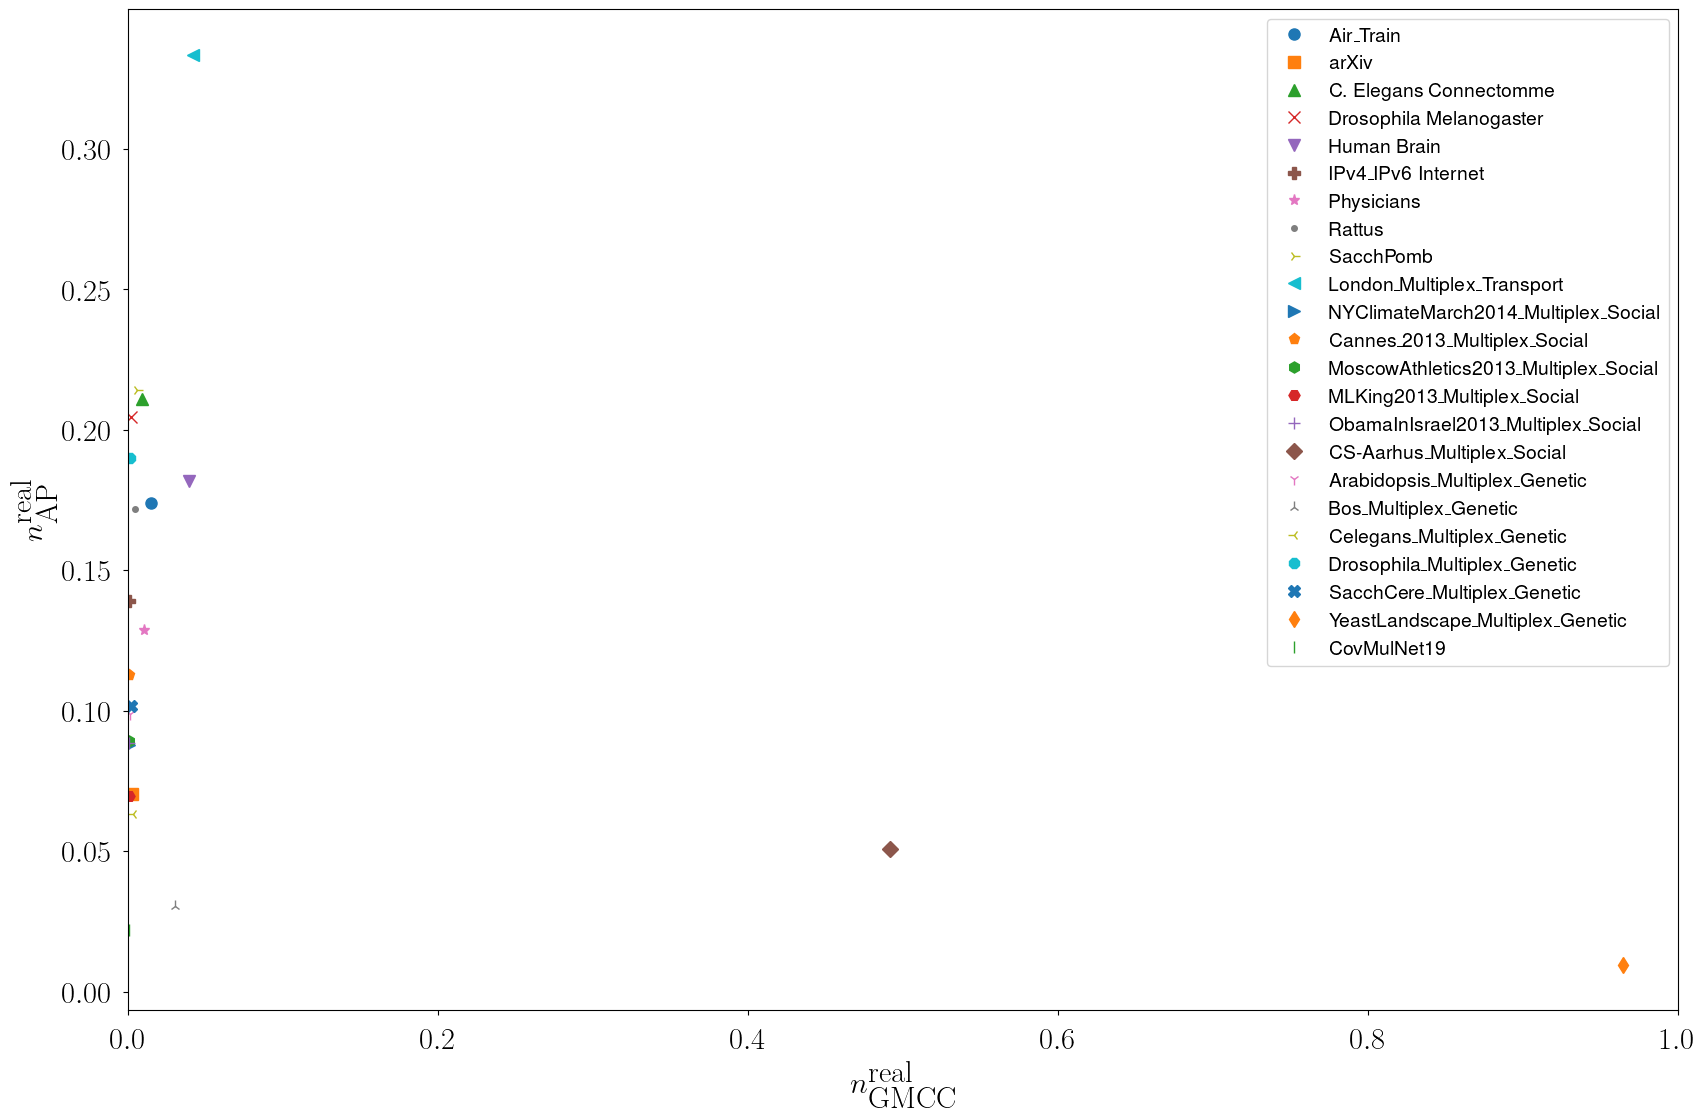

In [34]:
n_ap1, n_gcc1 = plot(relabeling=False, save=True)

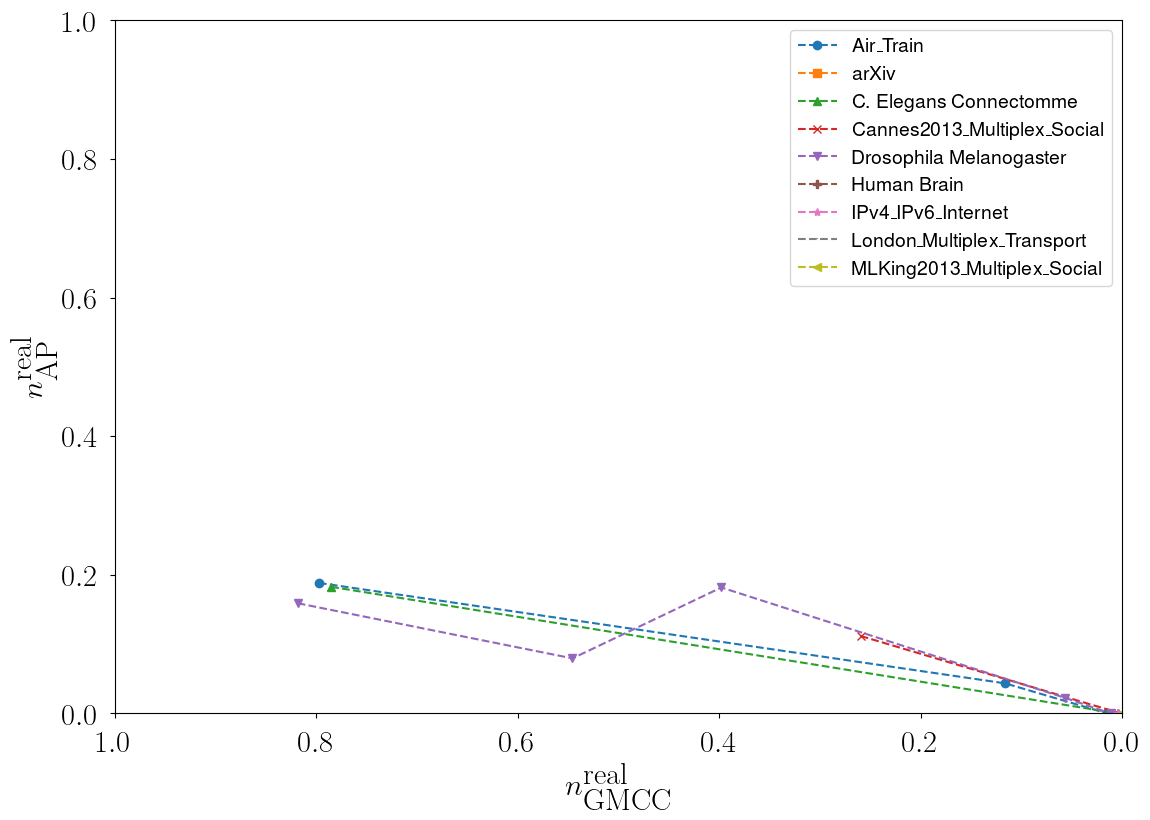

In [12]:
n_ap2, n_gcc2 = plot(relabeling=True, save=False)